# Monte Carlo Markov Chain sampling of COVID-19 infections

#### Author: leebond
#### Date: Feb 2020

In [1]:
import numpy as np
import scipy
import scipy.stats
import seaborn as sb
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd
import os, re, sys

# from helper_fun_model import *
from mcmcHelperFunctions import *

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
pd.set_option('display.max_columns',300)
pd.set_option('display.max_rows',300)

## Data source
#### source JHU

In [2]:
## Load data 
df = pd.read_csv("../data/daily_time_series_data_JHU.csv")

"""
Data Cleaning 
"""
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%y')
df.tail(3) # check new

,Province,Country,Date,Confirmed,Deaths,Recovered
2115,"San Antonio, TX",US,2020-02-22,1.0,0,0
2116,"Seattle, WA",US,2020-02-22,1.0,0,1
2117,"Tempe, AZ",US,2020-02-22,1.0,0,0


# Case 1: Simulate Hubei infection numbers

In [3]:
case = df[df['Country']=='China'] # get all of China's infection numbers
case = case.groupby('Date').agg({'Confirmed':'sum','Deaths':'sum','Recovered':'sum'}).reset_index()

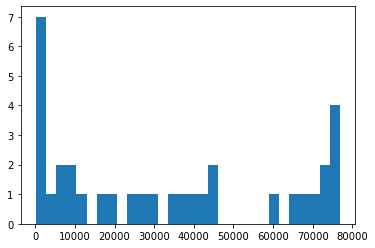

In [4]:
plt.hist(case['Confirmed'], bins = 30)
plt.show()

#### Using the daily change in infection number as a random variable we want to model
- the change in the infection numbers from day to day can tell us the force of infection per day. In other words, it can also be thought of as the infection rate which we could model as a random variable.
- to do so i simply do `diff()` which takes the first 'lag' of the infection column. Notice that the first row will not have any number since there is no 'lag'. Therefore, I fill the first record as 1 for simplicity yet it can't be 0 since there 'should' be some kind of new infection from day to day.

In [5]:
case['new infected'] = case['Confirmed'].diff().fillna(1)

In [6]:
case.head(10)

,Date,Confirmed,Deaths,Recovered,new infected
0,2020-01-20,144.0,0,0,1.0
1,2020-01-21,217.0,0,0,73.0
2,2020-01-22,547.0,17,28,330.0
3,2020-01-23,639.0,18,30,92.0
4,2020-01-24,916.0,26,36,277.0
5,2020-01-25,1399.0,42,39,483.0
6,2020-01-26,2062.0,56,49,663.0
7,2020-01-27,2863.0,82,58,801.0
8,2020-01-28,5494.0,131,101,2631.0
9,2020-01-29,6070.0,133,120,576.0


In [7]:
case.shape

(34, 5)

## EDA

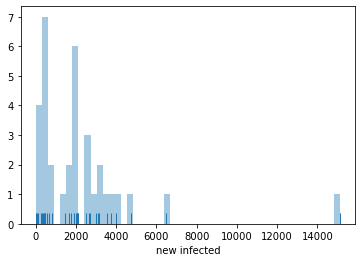

In [8]:
sb.distplot(case['new infected'], bins=50, kde=False, rug=True)

### Creating a gamma fit to the data
- the belief distribution is that the infection rate follows a gamma distribution.
- A gamma distribution is continuous, does not take on negative values and its flexible since it takes on two parameters; shape and scale
- several research papers have used gamma to model infection rates (google abit and you will see many using gamma)

In [9]:
mu = case['new infected'].mean()
sigma = case['new infected'].std()
mu, sigma

(2258.205882352941, 2733.550679969982)

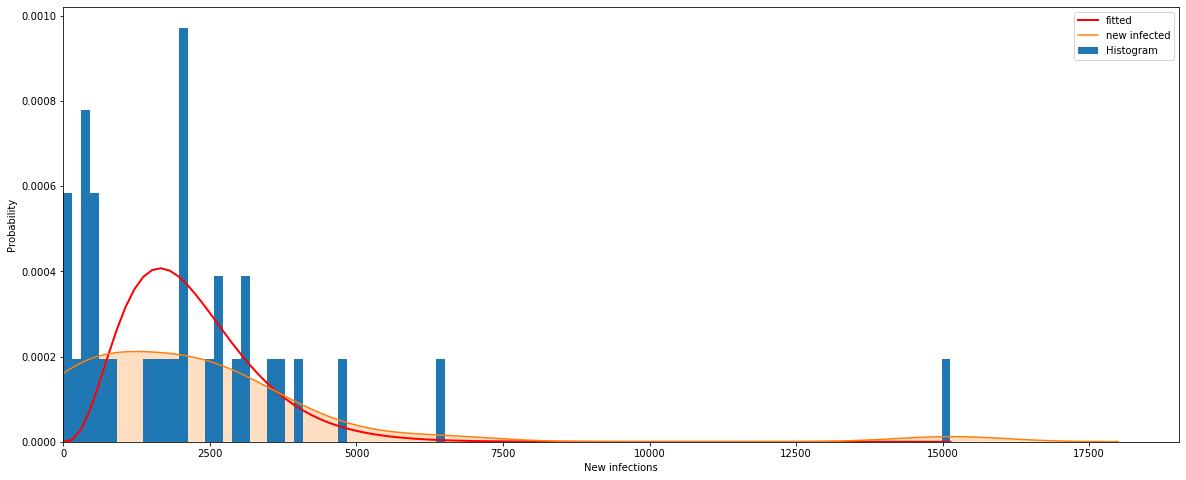

In [10]:
shape, scale = 4, 550 # manual
import scipy.special as sps
fig = plt.figure(figsize=(20,8))

count, gbins, ignored = plt.hist(case['new infected'], bins=100, normed=True, label='Histogram')
y = gbins**(shape-1)*(np.exp(-gbins/scale) /(sps.gamma(shape)*scale**shape))
plt.plot(gbins, y, linewidth=2, color='r', label='fitted')
sb.kdeplot(case['new infected'], shade=True).set(xlim=(0), label='KDE plot')

plt.ylabel("Probability")
plt.xlabel("New infections")
plt.show()

#### Some comments about the fitting
- The density plot is **missing some data** because we did not include counts from the earlier days of the outbreak (we have it but it is highly unreliable) 
- therefore the density distribution do not have new infection numbers that is near 0

# MCMC
- Why MCMC?
 - it offers us a robust method to draw samples from our posterior ie. allow us to bootstrap our data (new infection) to test a distribution
 - with the sampled distribution we can use MLE to find the parameters of the distribution
 - since our belief is a gamma distribution, we do the MLE for gamma
 - with the shape and scale parameters of gamma, we create an actual gamma distribution with these parameters, allowing us to forecast/predict samples that fall within the distribution of gamma. 
 - we do not know exactly what tomorrow's new infection number will be. But we can know the mean and variance of the gamma distribution + today's infection number = gives us tomorrow's infection count. 
 - Yes, it doesn't tell us in the future when and what the infection count will be (it doesnt forecast).

### Description
- MCMC
- use Metropolis Hastings' acceptance criterion
- checks for convergence using Gelman-Rubin's ratio

4 550
iter: 30000.0
Theta: 1000
Mean of samples: 2250.4681620258475, Stddev of samples: 1201.3179514676117
Theta: 1500
Mean of samples: 2253.2543034920773, Stddev of samples: 1178.4559699688975
Theta: 2000
Mean of samples: 2323.605955883361, Stddev of samples: 1095.1853267641777
Theta: 2500
Mean of samples: 2297.5597740959456, Stddev of samples: 1226.1476837121977
Theta: 3000
Mean of samples: 2328.4200193655333, Stddev of samples: 1213.77763151789
Gelman Rubin convergence ratio: 1.1842312269888484
iter: 65000.0
Theta: 1000
Mean of samples: 2182.2315033359737, Stddev of samples: 1044.1215405540493
Theta: 1500
Mean of samples: 2185.4027486812092, Stddev of samples: 1033.9906972541446
Theta: 2000
Mean of samples: 2131.2282244271023, Stddev of samples: 1038.0257440892103
Theta: 2500
Mean of samples: 2158.207765134494, Stddev of samples: 1210.2727595390854
Theta: 3000
Mean of samples: 2146.5849506016207, Stddev of samples: 1001.6502878017201
Gelman Rubin convergence ratio: 1.185666076134691

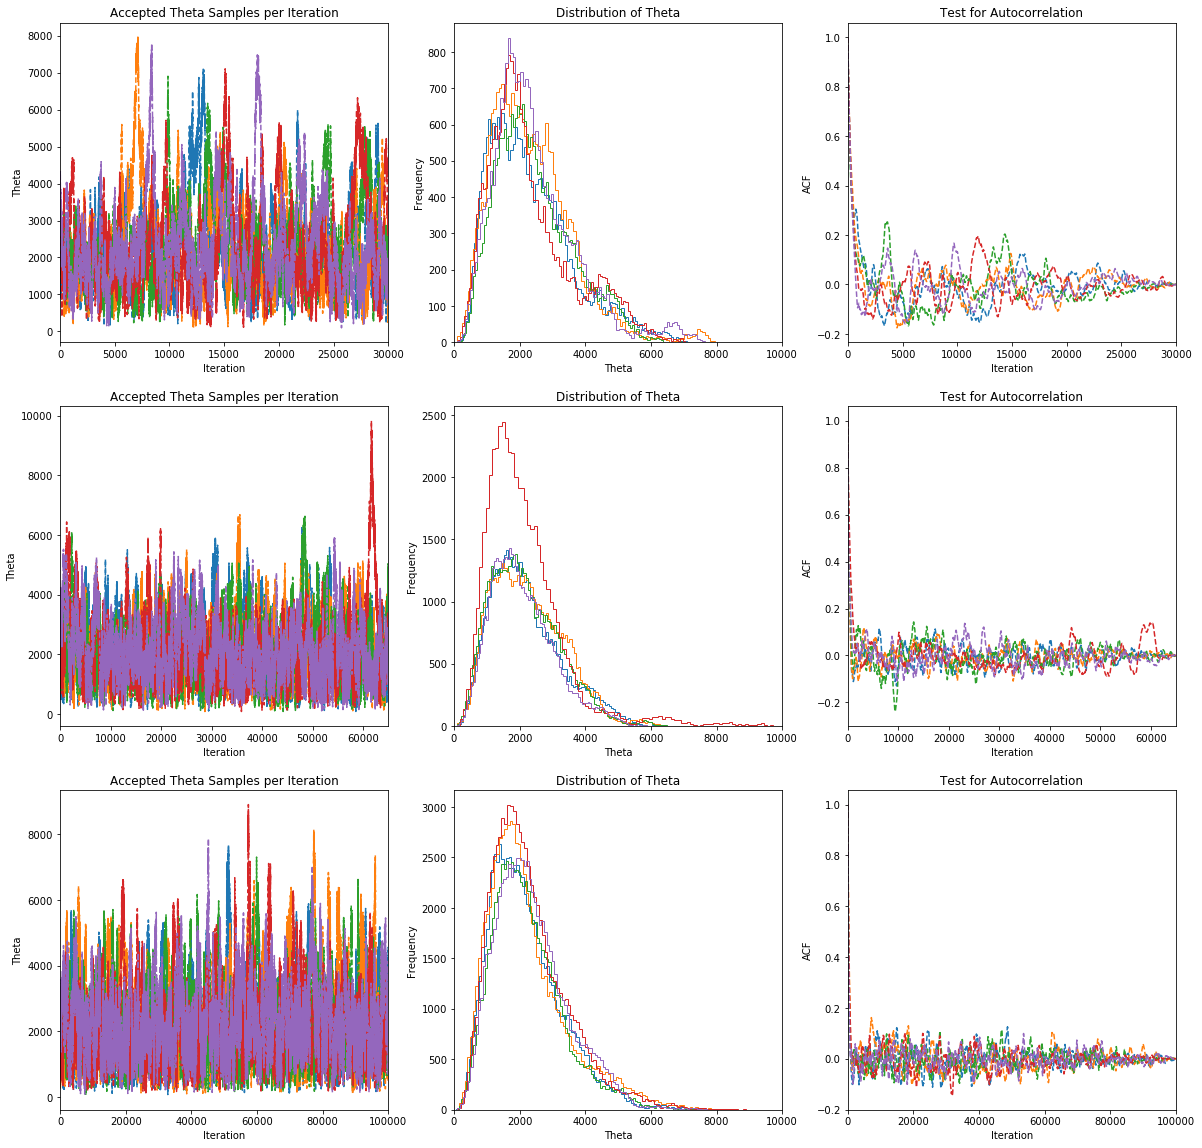

In [11]:
print(shape, scale) # manually chosen

mcmc_samples = MCMC(shape, scale, niters = np.linspace(3e4,1e5,3), thetas = np.arange(1000, 3500, 500))

## Result of MCMC Samples

In [12]:
a_i = b_i = 0
ab = [numericalMLEGamma(s) for s in mcmc_samples]
for x in ab:
    a_i += x[0]
    b_i += x[1]
print('Alpha: %s, Beta: %s' %(round(a_i/len(ab),1), round(b_i/len(ab),1)))
print('Mean infection count: %s' %(round(a_i/len(ab)*b_i/len(ab),1)))

Alpha: 4.1, Beta: 551.1
Mean infection count: 2265.6


## Case 2: Simulate Hubei infection numbers

In [13]:
case_hubei = df[df['Province']=='Hubei']

In [14]:
case_hubei.head(10)

,Province,Country,Date,Confirmed,Deaths,Recovered
0,Hubei,China,2020-01-20,136.0,0,0
6,Hubei,China,2020-01-21,209.0,0,0
21,Hubei,China,2020-01-22,444.0,17,28
59,Hubei,China,2020-01-23,444.0,17,28
92,Hubei,China,2020-01-24,549.0,24,31
133,Hubei,China,2020-01-25,761.0,40,32
177,Hubei,China,2020-01-26,1058.0,52,42
224,Hubei,China,2020-01-27,1423.0,76,45
275,Hubei,China,2020-01-28,3554.0,125,80
327,Hubei,China,2020-01-29,3554.0,125,88


In [15]:
case_hubei['new infected'] = case_hubei['Confirmed'].diff().fillna(1)

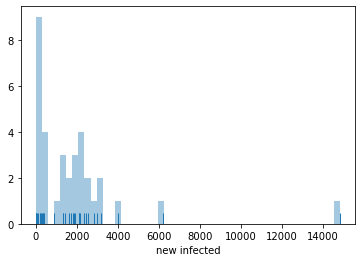

In [16]:
sb.distplot(case_hubei['new infected'], bins=50, kde=False, rug=True)

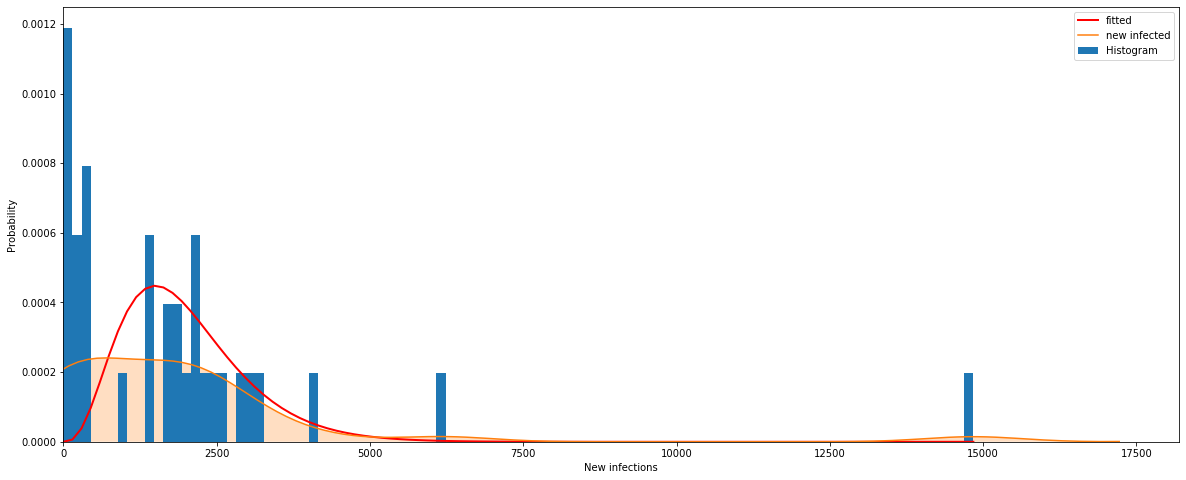

In [17]:
shape, scale = 4, 500 # manual
import scipy.special as sps
fig = plt.figure(figsize=(20,8))

count, gbins, ignored = plt.hist(case_hubei['new infected'], bins=100, normed=True, label='Histogram')
y = gbins**(shape-1)*(np.exp(-gbins/scale) /(sps.gamma(shape)*scale**shape))
plt.plot(gbins, y, linewidth=2, color='r', label='fitted')
sb.kdeplot(case_hubei['new infected'], shade=True).set(xlim=(0), label='KDE plot')

plt.ylabel("Probability")
plt.xlabel("New infections")
plt.show()

In [18]:
mu = case_hubei['new infected'].mean()
sigma = case_hubei['new infected'].std()
mu, sigma

(1880.8529411764705, 2674.63242597595)

4 500
iter: 30000.0
Theta: 1500
Mean of samples: 1847.4105685900138, Stddev of samples: 900.4963656793919
Theta: 2000
Mean of samples: 1910.7846795885866, Stddev of samples: 950.2049377919099
Theta: 2500
Mean of samples: 2010.899532285088, Stddev of samples: 1062.8766489914835
Theta: 3000
Mean of samples: 1937.1630702882962, Stddev of samples: 950.09020939654
Theta: 3500
Mean of samples: 2019.0224744961326, Stddev of samples: 942.9146166913844
Gelman Rubin convergence ratio: 1.1913219786748617
iter: 65000.0
Theta: 1500
Mean of samples: 1931.0706546584775, Stddev of samples: 922.3837293376442
Theta: 2000
Mean of samples: 1948.6942373610532, Stddev of samples: 975.7370242421326
Theta: 2500
Mean of samples: 2053.7203920631327, Stddev of samples: 1067.0906424692166
Theta: 3000
Mean of samples: 2049.1365035265912, Stddev of samples: 1026.5858471040638
Theta: 3500
Mean of samples: 1963.11225319271, Stddev of samples: 965.2376697348852
Gelman Rubin convergence ratio: 1.1863347358117151
iter: 

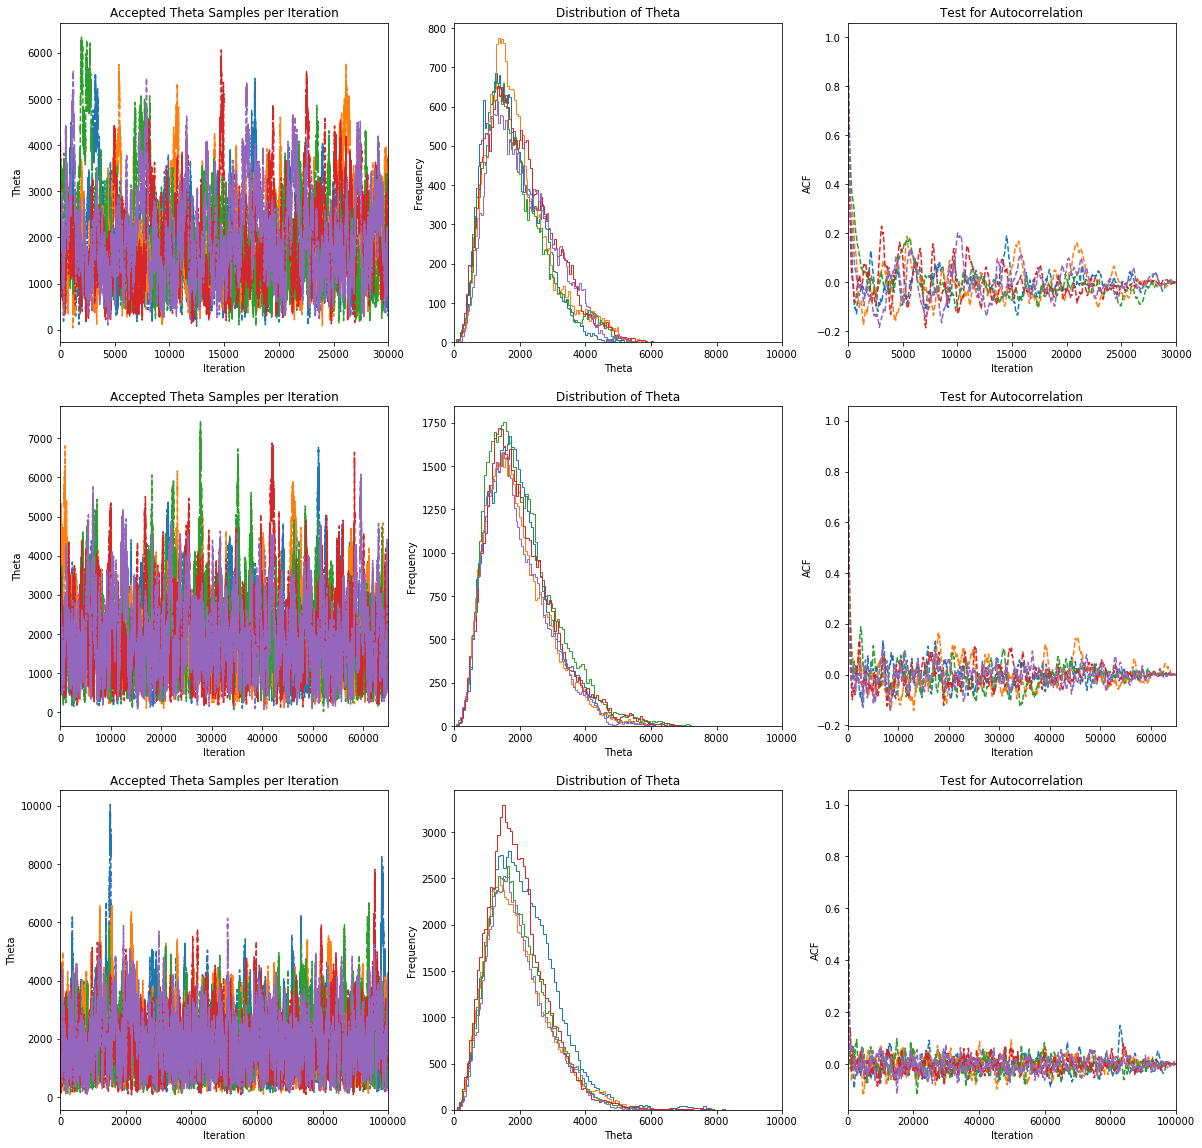

In [19]:
print(shape, scale) # manually chosen

mcmc_samples = MCMC(shape, scale, niters = np.linspace(3e4,1e5,3), thetas = np.arange(1500, 3501, 500))

### Result of MCMC Samples

In [20]:
a_i = b_i = 0
ab = [numericalMLEGamma(s) for s in mcmc_samples]
for x in ab:
    a_i += x[0]
    b_i += x[1]
print('Alpha: %s, Beta: %s' %(round(a_i/len(ab),1), round(b_i/len(ab),1)))
print('Mean infection count: %s' %(round(a_i/len(ab)*b_i/len(ab),1)))

Alpha: 4.3, Beta: 467.8
Mean infection count: 2012.2


## Case 3: Simulate China, ex-Hubei infection numbers

In [21]:
case_exHubei = df[(df['Country']=='China')&(df['Province']!='Hubei')]

In [22]:
case_exHubei = case_exHubei.groupby('Date').agg({'Confirmed':'sum','Deaths':'sum','Recovered':'sum'}).reset_index()

In [23]:
case_exHubei['new infected'] = case_exHubei['Confirmed'].diff().fillna(1)

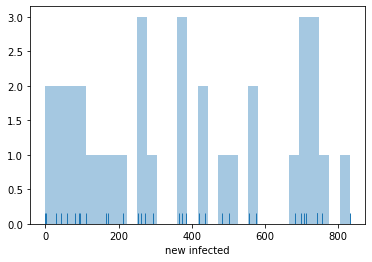

In [24]:
sb.distplot(case_exHubei['new infected'], bins=30, kde=False, rug=True)

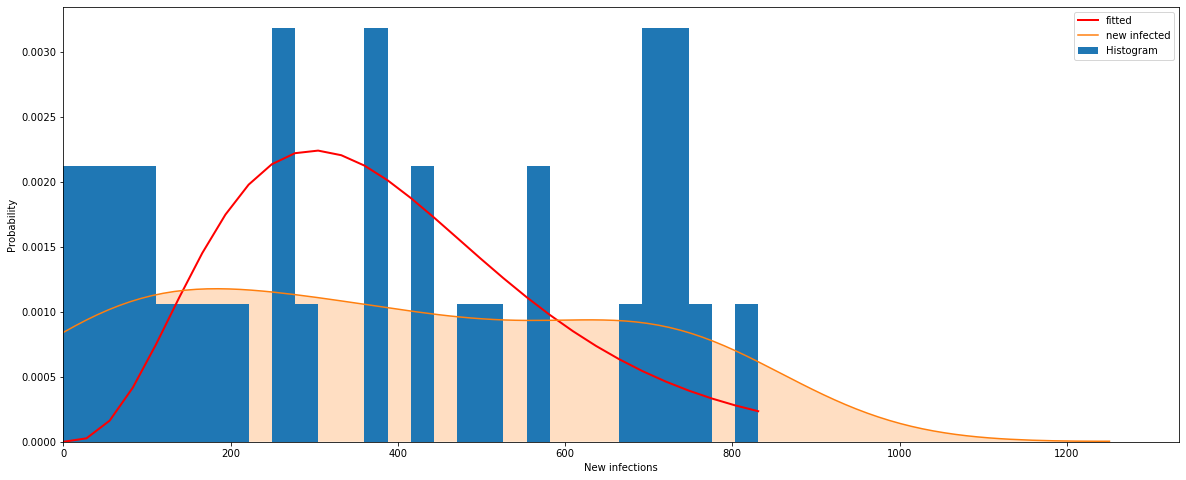

In [25]:
shape, scale = 4, 100 # manual
import scipy.special as sps
fig = plt.figure(figsize=(20,8))

count, gbins, ignored = plt.hist(case_exHubei['new infected'], bins=30, normed=True, label='Histogram')
y = gbins**(shape-1)*(np.exp(-gbins/scale) /(sps.gamma(shape)*scale**shape))
plt.plot(gbins, y, linewidth=2, color='r', label='fitted')
sb.kdeplot(case_exHubei['new infected'], shade=True).set(xlim=(0), label='KDE plot')

plt.ylabel("Probability")
plt.xlabel("New infections")
plt.show()

In [26]:
mu = case_exHubei['new infected'].mean()
sigma = case_exHubei['new infected'].std()
mu, sigma

(377.38235294117646, 267.68129112535735)

4 100
iter: 30000.0
Theta: 100
Mean of samples: 409.71197608206, Stddev of samples: 201.20402589419768
Theta: 600
Mean of samples: 409.37034012579073, Stddev of samples: 215.70925612808875
Theta: 1100
Mean of samples: 425.7029311282438, Stddev of samples: 226.24645151422308
Theta: 1600
Mean of samples: 440.8244392785582, Stddev of samples: 214.12090776921983
Theta: 2100
Mean of samples: 388.95492505022287, Stddev of samples: 221.6506300825705
Gelman Rubin convergence ratio: 1.1891634491092553
iter: 65000.0
Theta: 100
Mean of samples: 384.74475778683313, Stddev of samples: 183.8573814692863
Theta: 600
Mean of samples: 381.9202033302459, Stddev of samples: 179.12435628053112
Theta: 1100
Mean of samples: 434.8732913596067, Stddev of samples: 226.9096370039413
Theta: 1600
Mean of samples: 403.6728769444539, Stddev of samples: 206.1145563235876
Theta: 2100
Mean of samples: 426.8363521126627, Stddev of samples: 240.33881409517005
Gelman Rubin convergence ratio: 1.185863104033115
iter: 100000

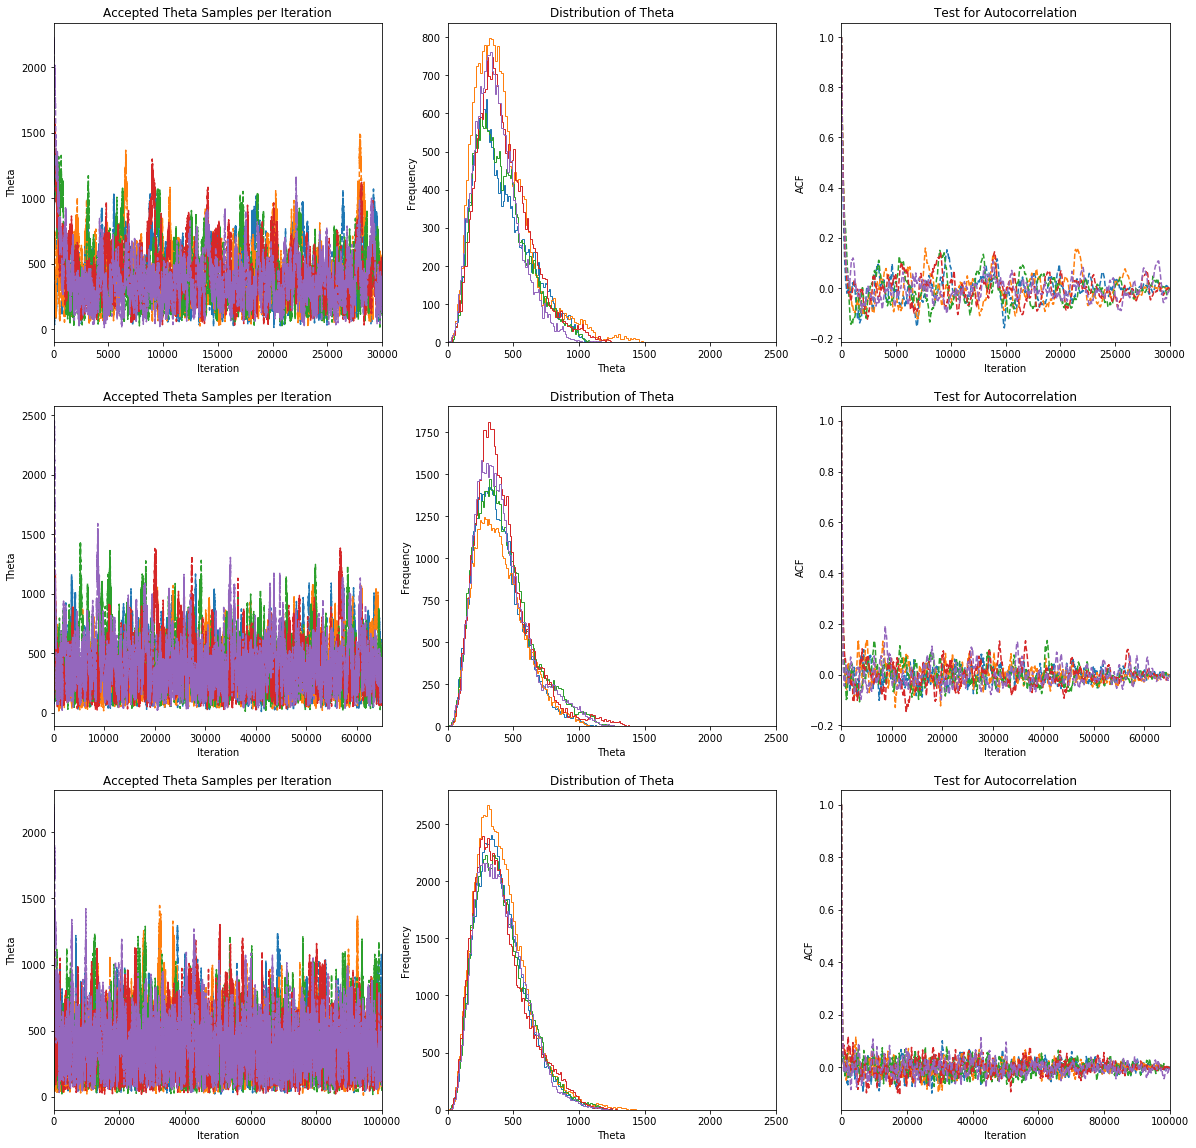

In [27]:
print(shape, scale) # manually chosen

mcmc_samples = MCMC(shape, scale, sigma=25, niters = np.linspace(3e4,1e5,3), thetas = np.arange(100, 2101, 500))

### Result of MCMC Samples

In [28]:
a_i = b_i = 0
ab = [numericalMLEGamma(s) for s in mcmc_samples]
for x in ab:
    a_i += x[0]
    b_i += x[1]
print('Alpha: %s, Beta: %s' %(round(a_i/len(ab),1), round(b_i/len(ab),1)))
print('Mean infection count: %s' %(round(a_i/len(ab)*b_i/len(ab),1)))

Alpha: 4.2, Beta: 96.9
Mean infection count: 408.2


## Case 4: Simulate ex-China infection numbers

In [29]:
case_exChina = df[(df['Country']!='China')]

In [30]:
case_exChina = case_exChina.groupby('Date').agg({'Confirmed':'sum','Deaths':'sum','Recovered':'sum'}).reset_index()

In [31]:
case_exChina['new infected'] = case_exChina['Confirmed'].diff().fillna(1)

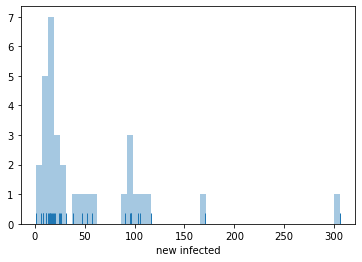

In [32]:
sb.distplot(case_exChina['new infected'], bins=50, kde=False, rug=True)

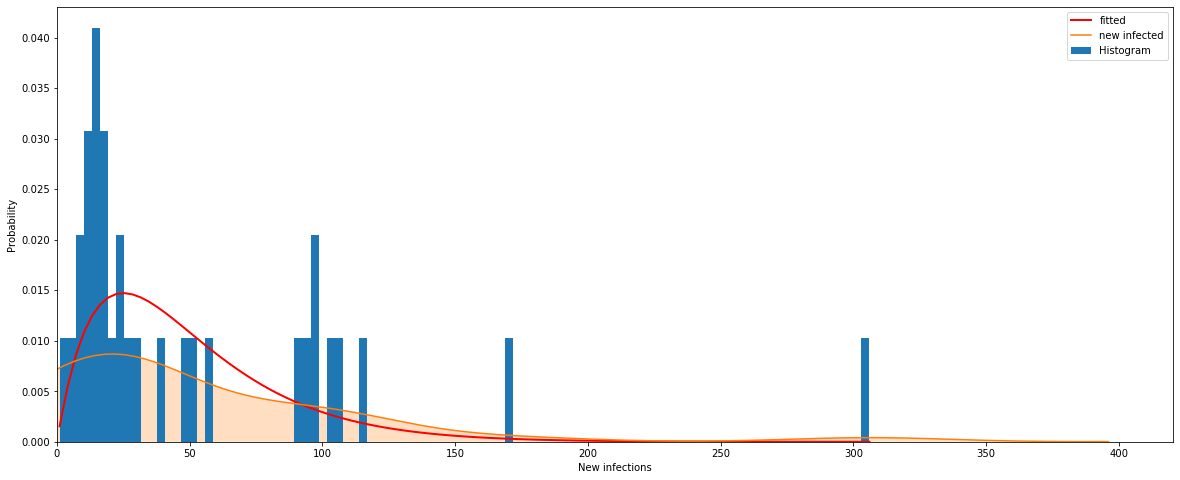

In [33]:
shape, scale = 2, 25 # manual
import scipy.special as sps
fig = plt.figure(figsize=(20,8))

count, gbins, ignored = plt.hist(case_exChina['new infected'], bins=100, normed=True, label='Histogram')
y = gbins**(shape-1)*(np.exp(-gbins/scale) /(sps.gamma(shape)*scale**shape))
plt.plot(gbins, y, linewidth=2, color='r', label='fitted')
sb.kdeplot(case_exChina['new infected'], shade=True).set(xlim=(0), label='KDE plot')

plt.ylabel("Probability")
plt.xlabel("New infections")
plt.show()

In [34]:
mu = case_exChina['new infected'].mean()
sigma = case_exChina['new infected'].std()
mu, sigma

(52.1875, 62.64772863580775)

2 25
iter: 30000.0
Theta: 10
Mean of samples: 52.1504294292825, Stddev of samples: 35.81453626622519
Theta: 60
Mean of samples: 51.531626028297055, Stddev of samples: 35.40614593551935
Theta: 110
Mean of samples: 52.506177347340916, Stddev of samples: 34.36630233824841
Theta: 160
Mean of samples: 51.04789897707383, Stddev of samples: 33.675623669838
Theta: 210
Mean of samples: 53.95307242134153, Stddev of samples: 38.12376958169983
Gelman Rubin convergence ratio: 1.1849372581957938
iter: 65000.0
Theta: 10
Mean of samples: 50.88786451131797, Stddev of samples: 33.35342906888724
Theta: 60
Mean of samples: 52.26506164053743, Stddev of samples: 37.08740568034209
Theta: 110
Mean of samples: 48.1282115152671, Stddev of samples: 30.69277066593031
Theta: 160
Mean of samples: 51.05457948823246, Stddev of samples: 34.88690478460136
Theta: 210
Mean of samples: 50.877808670129404, Stddev of samples: 35.15519750068206
Gelman Rubin convergence ratio: 1.1840909838882903
iter: 100000.0
Theta: 10
Mean 

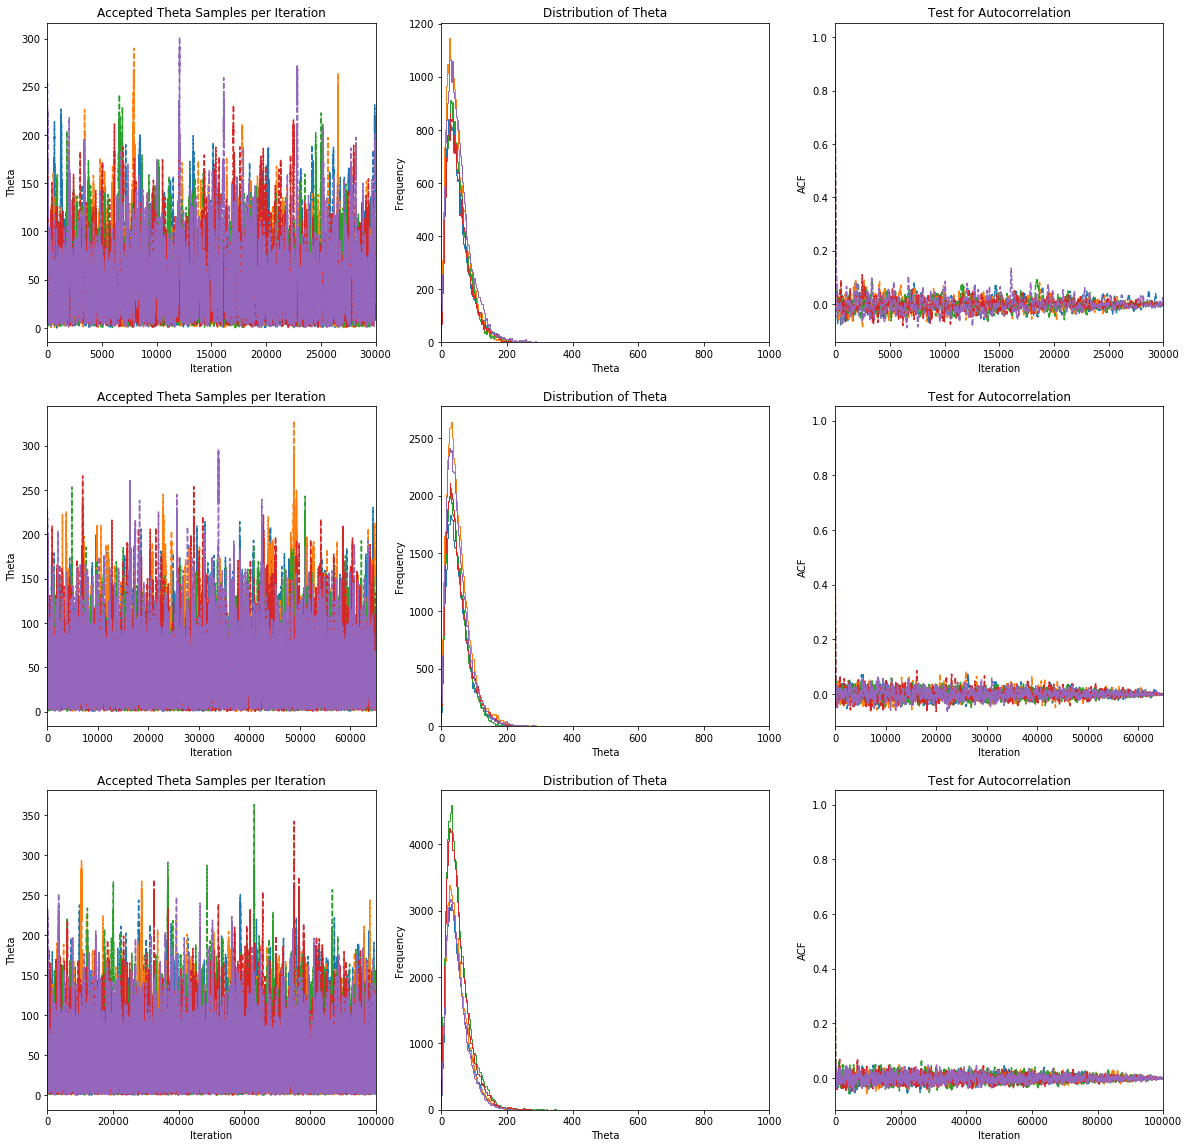

In [35]:
print(shape, scale) # manually chosen
mcmc_samples = MCMC(shape, scale, sigma=10, niters = np.linspace(3e4,1e5,3), thetas = np.arange(10, 260, 50))

## Result of MCMC Samples

In [36]:
a_i = b_i = 0
ab = [numericalMLEGamma(s) for s in mcmc_samples]
for x in ab:
    a_i += x[0]
    b_i += x[1]
print('Alpha: %s, Beta: %s' %(round(a_i/len(ab),1), round(b_i/len(ab),1)))
print('Mean infection count: %s' %(round(a_i/len(ab)*b_i/len(ab),1)))

Alpha: 2.2, Beta: 22.8
Mean infection count: 51.2
